## Marcel For The NFL

Player projection systems in the NFL mainly comes in the form of fantasy football projections, in which these systems try to project player performance measured by fantasy points in different types of leagues. Most of the methodology behind these systems is murky, and to my knowledge the accuracy of these systems isn't usually made public. This is why I decided to create a very 'simple', open-source projection system for the NFL, based on the Marcel projection system.

The Marcel projection system was developed by Tom Tango for baseball player projections (It has also been translated to sports such as [hockey](https://ownthepuck.wordpress.com/2015/09/05/using-marcels-to-forecast-player-performance-in-hockey/) and [basketball](https://www.basketball-reference.com/about/projections.html). The system is incredibly simple yet incredibly powerful, usually performing on par with much more complex projections systems for [baseball](http://www.insidethebook.com/ee/index.php/site/comments/forecast_evaluations/). The idea is this: weight each of the past three seasons of player's career, giving more weight to the most recent season (I'll discuss how these weights are established later), then get the league average for those seasons with the same amount of 'playing time', and add those numbers together, which regresses the player's performance towards the mean. After that, use an aging curve (for this I used the [Delta Method](https://mglbaseball.com/2016/12/21/a-new-method-of-constructing-more-accurate-aging-curves/) (with a [tweak using the harmonic mean](https://www.beyondtheboxscore.com/2011/5/31/2199146/hitter-aging-curves)) to determine the how the player should play relative to last year as a result of being one year older.

In baseball, the 'playing time' component is plate appearances (for hitters), and so in my opinion parallels for football would by rushing attempts (for running backs), passing attempts (for quarterbacks), and targets (for running backs, receivers and tight ends). We can project a variety of statistics for each player using this methodology, but for this project, I'll be looking at two: DYAR (Defensive Adjusted Yards Above Replacement) and Yards, with DYAR being developed by Football Outsiders and can be read about [here](https://www.footballoutsiders.com/info/glossary). Since not all players have three years of experience, I'll also be using modified weights for players with only two seasons, as well as players with only one year of experience. 


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from scipy import stats
import statistics

In [87]:
def get_harmonic_mean(my_list):

    sum = 0.0
    for i in my_list:
        sum += 1.0 / i
    return len(my_list) / sum

## Gathering, Cleaning Data

In [88]:
# Get Data from /Data
qb_bdays = pd.read_csv("Data/qb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
rb_bdays = pd.read_csv("Data/rb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
wr_bdays = pd.read_csv("Data/wr_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
te_bdays = pd.read_csv("Data/te_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')

qb_stats = pd.read_csv("Data/qbdata.csv", thousands=',')
rb_stats_rush = pd.read_csv("Data/rbdata_rush.csv", thousands=',')
rb_stats_rec = pd.read_csv("Data/rbdata_rec.csv", thousands=',')
wr_stats = pd.read_csv("Data/wrdata.csv", thousands=',')
te_stats = pd.read_csv("Data/tedata.csv", thousands=',')

#Drop Players with unknown birthdays, convert birthdays to datetimes
qb_bdays.dropna(inplace = True)
qb_bdays['Birthdate'] = pd.to_datetime(qb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

rb_bdays.dropna(inplace = True)
rb_bdays['Birthdate'] = pd.to_datetime(rb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

wr_bdays.dropna(inplace = True)
wr_bdays['Birthdate'] = pd.to_datetime(wr_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

te_bdays.dropna(inplace = True)
te_bdays['Birthdate'] = pd.to_datetime(te_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

#left join stats with player birthdate
qb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
qb_stats = qb_stats.merge(qb_bdays, on = 'Player', how = 'left')

rb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
rb_stats_rush = rb_stats_rush.merge(rb_bdays, on = 'Player', how = 'left')
rb_stats_rec = rb_stats_rec.merge(rb_bdays, on = 'Player', how = 'left')

wr_bdays.rename(columns = {'Name':'Player'}, inplace = True)
wr_stats = wr_stats.merge(wr_bdays, on = 'Player', how = 'left')

te_bdays.rename(columns = {'Name':'Player'}, inplace = True)
te_stats = te_stats.merge(te_bdays, on = 'Player', how = 'left')

#Convert Year in player stats to datetime
qb_stats['Year'] = pd.to_datetime(qb_stats['Year'], format = '%Y')
rb_stats_rush['Year'] = pd.to_datetime(rb_stats_rush['Year'], format = '%Y')
rb_stats_rec['Year'] = pd.to_datetime(rb_stats_rec['Year'], format = '%Y')
wr_stats['Year'] = pd.to_datetime(wr_stats['Year'], format = '%Y')
te_stats['Year'] = pd.to_datetime(te_stats['Year'], format = '%Y')

# get player age at start of each season
qb_stats = qb_stats[~(qb_stats['Birthdate'].isnull())]
qb_stats['Age'] = (qb_stats['Year'] - qb_stats['Birthdate'])
qb_stats['Age'] = qb_stats['Age'].apply(lambda x: float(x.days)/365)

rb_stats_rush = rb_stats_rush[~(rb_stats_rush['Birthdate'].isnull())]
rb_stats_rush['Age'] = (rb_stats_rush['Year'] - rb_stats_rush['Birthdate'])
rb_stats_rush['Age'] = rb_stats_rush['Age'].apply(lambda x: float(x.days)/365)

rb_stats_rec = rb_stats_rec[~(rb_stats_rec['Birthdate'].isnull())]
rb_stats_rec['Age'] = (rb_stats_rec['Year'] - rb_stats_rec['Birthdate'])
rb_stats_rec['Age'] = rb_stats_rec['Age'].apply(lambda x: float(x.days)/365)

wr_stats = wr_stats[~(wr_stats['Birthdate'].isnull())]
wr_stats['Age'] =(wr_stats['Year'] - wr_stats['Birthdate'])
wr_stats['Age'] = wr_stats['Age'].apply(lambda x: float(x.days)/365)

te_stats = te_stats[~(te_stats['Birthdate'].isnull())]
te_stats['Age'] =(te_stats['Year'] - te_stats['Birthdate'])
te_stats['Age'] = te_stats['Age'].apply(lambda x: float(x.days)/365)

#Get Differences Between Year -> Year t now includes DYAR for year t+1 for training
#Last Year is NA for DYAR_-1
qb_stats['DYAR_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats_rush['DYAR_t+1'] = rb_stats_rush.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats_rec['DYAR_t+1'] = rb_stats_rec.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
wr_stats['DYAR_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
te_stats['DYAR_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)

qb_stats['Yds_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['Yds'].shift(-1)
rb_stats_rush['Yds_t+1'] = rb_stats_rush.sort_values('Age').groupby(['Player','Birthdate'])['Yds'].shift(-1)
rb_stats_rec['Yds_t+1'] = rb_stats_rec.sort_values('Age').groupby(['Player','Birthdate'])['Yds'].shift(-1)
wr_stats['Yds_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['Yds'].shift(-1)
te_stats['Yds_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['Yds'].shift(-1)

# Get passes, rushes, passes to for year t+1
qb_stats['Passes_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['Passes'].shift(-1)
rb_stats_rush['Rushes_t+1'] = rb_stats_rush.sort_values('Age').groupby(['Player','Birthdate'])['Rushes'].shift(-1)
rb_stats_rec['Targets_t+1'] = rb_stats_rec.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)
wr_stats['Targets_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)
te_stats['Targets_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)

#take % sign from Suc_rate, Catch_rate
rb_stats_rush['Suc_rate'] = rb_stats_rush['Suc_rate'].str.extract(r"(\d+)%")
rb_stats_rush['Suc_rate'] = rb_stats_rush['Suc_rate'].fillna(0)

rb_stats_rec['Catch_rate'] = rb_stats_rec['Catch_rate'].str.extract(r"(\d+)%")
rb_stats_rec['Catch_rate'] = rb_stats_rec['Catch_rate'].fillna(0)

wr_stats['Catch_rate'] = wr_stats['Catch_rate'].str.extract(r"(\d+)%")
wr_stats['Catch_rate'] = wr_stats['Catch_rate'].fillna(0)

te_stats['Catch_rate'] = te_stats['Catch_rate'].str.extract(r"(\d+)%")
te_stats['Catch_rate'] = te_stats['Catch_rate'].fillna(0)

## Functions for generating statistics for analysis

In [89]:
## Get league average DYAR/Rush, DYAR/Pass, DYAR/Target
def get_avg_stat(position,stat):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
    elif position == "te":
        df = te_stats
        touches = "Targets"
        
    league_avg = df.groupby('Year').sum()[stat] / df.groupby('Year').sum()[touches]
    avg_stat = []
    for index, row in df.iterrows():
        avg_stat.append(row[touches] * league_avg[row['Year']])
    return avg_stat

def get_past_stat(stat,df):
    # Get STAT from 1, 2 and 3 years ago for regression model
    df['{}_t-1'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(1)
    df['{}_t-2'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(2)
    df['{}_t-3'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(3)


In [90]:
rb_stats_rush['ADYAR'] = get_avg_stat('rb_rush','DYAR')
rb_stats_rec['ADYAR'] = get_avg_stat('rb_rec','DYAR')
qb_stats['ADYAR'] = get_avg_stat('qb','DYAR')
wr_stats['ADYAR'] = get_avg_stat('wr','DYAR')
te_stats['ADYAR'] = get_avg_stat('te','DYAR')

rb_stats_rush['AYds'] = get_avg_stat('rb_rush','Yds')
rb_stats_rec['AYds'] = get_avg_stat('rb_rec','Yds')
qb_stats['AYds'] = get_avg_stat('qb','Yds')
wr_stats['AYds'] = get_avg_stat('wr','Yds')
te_stats['AYds'] = get_avg_stat('te','Yds')

get_past_stat('Rushes',rb_stats_rush)
get_past_stat('Targets',rb_stats_rec)
get_past_stat('Passes',qb_stats)
get_past_stat('Targets',wr_stats)
get_past_stat('Targets',te_stats)

get_past_stat('DYAR',rb_stats_rush)
get_past_stat('DYAR',rb_stats_rec)
get_past_stat('DYAR',qb_stats)
get_past_stat('DYAR',wr_stats)
get_past_stat('DYAR',te_stats)

get_past_stat('ADYAR',rb_stats_rush)
get_past_stat('ADYAR',rb_stats_rec)
get_past_stat('ADYAR',qb_stats)
get_past_stat('ADYAR',wr_stats)
get_past_stat('ADYAR',te_stats)

get_past_stat('Yds',rb_stats_rush)
get_past_stat('Yds',rb_stats_rec)
get_past_stat('Yds',qb_stats)
get_past_stat('Yds',wr_stats)
get_past_stat('Yds',te_stats)

get_past_stat('AYds',rb_stats_rush)
get_past_stat('AYds',rb_stats_rec)
get_past_stat('AYds',qb_stats)
get_past_stat('AYds',wr_stats)
get_past_stat('AYds',te_stats)

## EDA

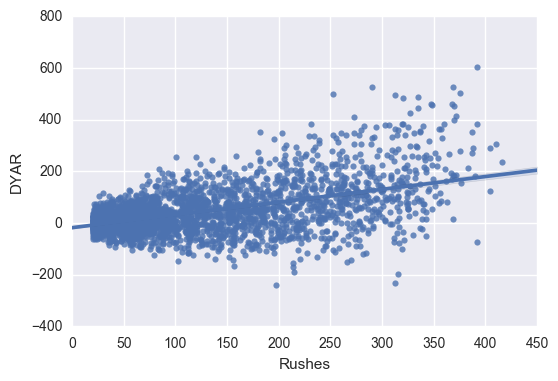

In [91]:
#DYAR compared to rushes
sns.regplot(rb_stats_rush['Rushes'],rb_stats_rush['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

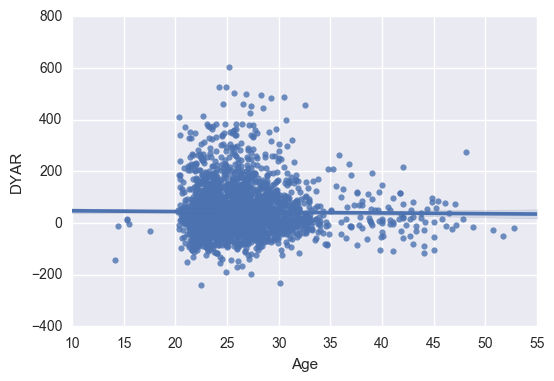

In [92]:
#Regression of age and DYAR
plt.figure(1)
sns.regplot(rb_stats_rush['Age'],rb_stats_rush['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

In [93]:
#rb DYAR over time
rb_career_data = rb_stats_rush[~pd.isnull(rb_stats_rush['DYAR_t+1'])]
rb_age_means = rb_career_data.groupby(pd.cut(rb_career_data['Age'],np.arange(21,35,1))).mean()

#qb DYAR over time
qb_career_data = qb_stats[~pd.isnull(qb_stats['DYAR_t+1'])]
qb_age_means = qb_career_data.groupby(pd.cut(qb_career_data['Age'],np.arange(21,41,1))).mean()

#wr DYAR over time
wr_career_data = wr_stats[~pd.isnull(wr_stats['DYAR_t+1'])]
wr_age_means = wr_career_data.groupby(pd.cut(wr_career_data['Age'],np.arange(21,35,1))).mean()

#te DYAR over time
te_career_data = te_stats[~pd.isnull(te_stats['DYAR_t+1'])]
te_age_means = te_career_data.groupby(pd.cut(te_career_data['Age'],np.arange(21,35,1))).mean()


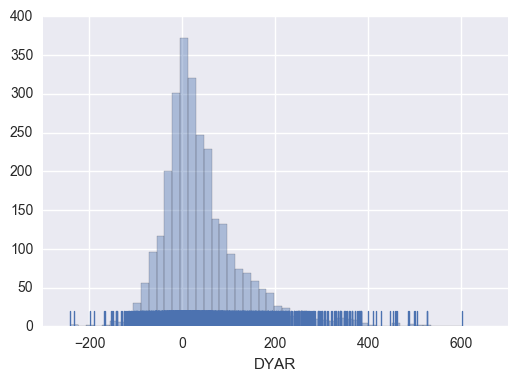

In [94]:
# distritbution of DYAR
plt.figure(1)
x = rb_stats_rush['DYAR']
sns.distplot(x, kde=False, rug=True);
plt.show()

## Aging Curves

In [95]:
#Constructing aging curve with Delta Model

def delta_model(position,stat):
    '''Delta Model: Take difference of stat between players who played consecutive years,
    then divide harmonic mean of the touches (touches,touches_t+t) by the touches in each year 
    to get touches relative to harmonic mean. Multiply these by the stat, then take the difference between years. 
    Divide this by the harmoinc mean to get the difference in stat 'per touch' ex: DYAR difference per Rush
    Exclude all players' last year to avoid  survivorship bias
    Takes in position group as parameter, returns Series with aging curve penalty for year t to t+1'''
    
    
    if position == "RB_rush":
        df = rb_stats_rush
        #Only players who played in consecutive years, also excludes last year of career
        df = df[~pd.isnull(df['{}_t+1'.format(stat)])]
        #Get Harmonic mean
        df['HMean'] = df[['Rushes','Rushes_t+1']].apply(get_harmonic_mean,axis = 1)
        #Perform operation described above
        df['{}_diff'.format(stat)] = df['HMean']/df['Rushes_t+1']*df['{}_t+1'.format(stat)] - df['HMean']/df['Rushes']*df[stat]
        df['{}_diff'.format(stat)] = df['{}_diff'.format(stat)]/df['HMean']
    elif position == "RB_rec":
        df = rb_stats_rec
        df = df[~pd.isnull(df['{}_t+1'.format(stat)])]
        df['HMean'] = df[['Targets','Targets_t+1']].apply(get_harmonic_mean,axis = 1)
        df['{}_diff'.format(stat)] = df['HMean']/df['Targets_t+1']*df['{}_t+1'.format(stat)] - df['HMean']/df['Targets']*df[stat]
        df['{}_diff'.format(stat)] = df['{}_diff'.format(stat)]/df['HMean']
    elif position == "QB":
        df = qb_stats
        df = df[~pd.isnull(df['{}_t+1'.format(stat)])]
        df['HMean'] = df[['Passes','Passes_t+1']].apply(get_harmonic_mean,axis = 1)
        df['{}_diff'.format(stat)] = df['HMean']/df['Passes_t+1']*df['{}_t+1'.format(stat)] - df['HMean']/df['Passes']*df[stat]
        df['{}_diff'.format(stat)] = df['{}_diff'.format(stat)]/df['HMean']
    elif position == "WR":
        df = wr_stats
        df = df[~pd.isnull(df['{}_t+1'.format(stat)])]
        df['HMean'] = df[['Targets','Targets_t+1']].apply(get_harmonic_mean,axis = 1)
        df['{}_diff'.format(stat)] = df['HMean']/df['Targets_t+1']*df['{}_t+1'.format(stat)] - df['HMean']/df['Targets']*df[stat]
        df['{}_diff'.format(stat)] = df['{}_diff'.format(stat)]/df['HMean']
    elif position == "TE":
        df = te_stats
        df = df[~pd.isnull(df['{}_t+1'.format(stat)])]
        df['HMean'] = df[['Targets','Targets_t+1']].apply(get_harmonic_mean,axis = 1)
        df['{}_diff'.format(stat)] = df['HMean']/df['Targets_t+1']*df['{}_t+1'.format(stat)] - df['HMean']/df['Targets']*df[stat]
        df['{}_diff'.format(stat)] = df['{}_diff'.format(stat)]/df['HMean']    
    
    if position == 'QB':
        aging_penalties = df.groupby(pd.cut(df['Age'],np.arange(21,41,1))).mean()
    else:
        aging_penalties = df.groupby(pd.cut(df['Age'],np.arange(21,35,1))).mean()
    
    return aging_penalties

In [96]:
def get_age_pens(df,position,stat):
    
    # Getting age penalty for each age (groupby returns years like (20,21], want to extract the age 21 from that)
    lst = []
    for age in df.index.values:
        lst.append(float(age[5:7]))

    # adjusting for sample size - small samples are pulled closer to 0 by multiplying their relative size * effect
    if position == 'qb':
        sample_mean = df.groupby(pd.cut(df['Age'],np.arange(21,35,1)))[stat].count().values.mean()
        sample_sizes = df.groupby(pd.cut(df['Age'],np.arange(21,41,1)))[stat].count().values
    else:
        sample_mean = df.groupby(pd.cut(df['Age'],np.arange(21,35,1)))[stat].count().values.mean()
        sample_sizes = df.groupby(pd.cut(df['Age'],np.arange(21,35,1)))[stat].count().values

    sample_sizes = sample_sizes / sample_mean
    age_means = []
    df_vals = df['{}_diff'.format(stat)].values
    for i, val in enumerate(sample_sizes, start=0):
        if val < .5:
            age_means.append(val * df_vals[i])
        else:
            age_means.append(df_vals[i])
    df_pens = pd.DataFrame({"Age":lst,"Penalty":age_means})
    return df_pens

In [97]:
rb_age_rush = delta_model("RB_rush",'DYAR')
rb_age_rec = delta_model("RB_rec",'DYAR')
qb_age = delta_model("QB",'DYAR')
wr_age = delta_model("WR",'DYAR')
te_age = delta_model("TE",'DYAR')


rb_pens_rush = get_age_pens(rb_age_rush,'rb','DYAR')
rb_pens_rec = get_age_pens(rb_age_rec,'rb','DYAR')
qb_pens = get_age_pens(qb_age,'qb','DYAR')
wr_pens = get_age_pens(wr_age,'wr','DYAR')
te_pens = get_age_pens(te_age,'te','DYAR')

## Graphing Aging Curves

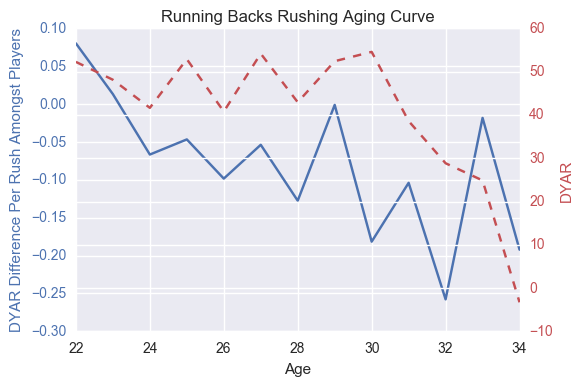

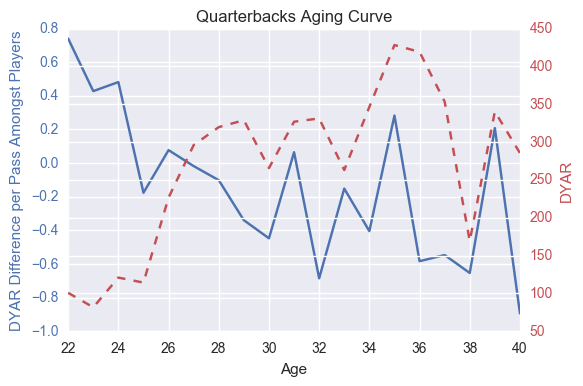

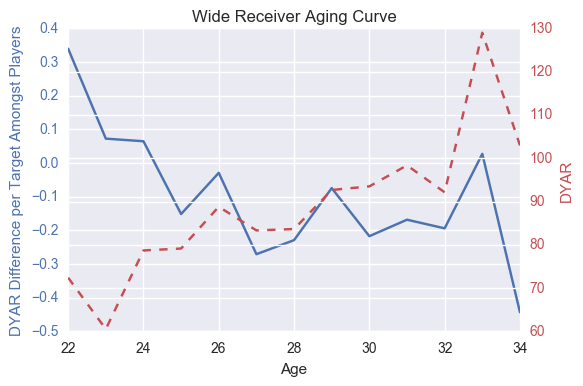

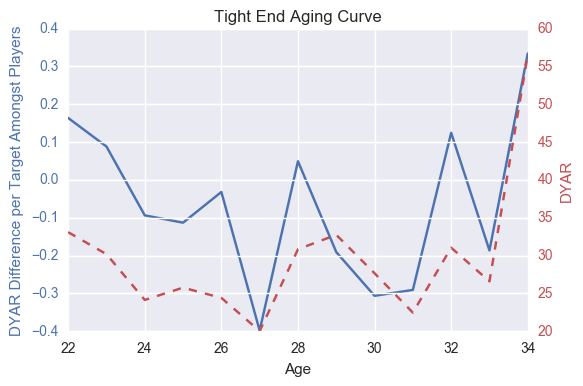

In [98]:
#RB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(rb_pens_rush['Age'], rb_pens_rush['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference Per Rush Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(rb_pens_rush['Age'], rb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')
ax1.set_title('Running Backs Rushing Aging Curve')
fig.tight_layout()

#QB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(qb_pens['Age'], qb_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Pass Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(qb_pens['Age'], qb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')
ax1.set_title('Quarterbacks Aging Curve')
fig.tight_layout()
#WR DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(wr_pens['Age'], wr_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(wr_pens['Age'], wr_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')
ax1.set_title('Wide Receiver Aging Curve')
fig.tight_layout()
#TE DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(te_pens['Age'], te_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(te_pens['Age'], te_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')
ax1.set_title('Tight End Aging Curve')
fig.tight_layout()
plt.show()

Graphs Above: On the left Y-Axis is the change in DYAR per Rush/Pass/Target from the year before. On the right is the average DYAR in that year

## Marcel Model

## Regression Analysis For Season Weights

In [99]:
# Creating Regression Model(s) to get season weights
# Model 1 predicts DYAR in year t based off of DYAR in years t-1,t-2,t-3
# Model 2 predicts DYAR in year t based off of DYAR in years t-1,t-2

import statsmodels.api as sm

def get_weights_touches(position):
    touches = ''
    threshold = 0
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        threshold = 50
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        threshold = 50    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Targets"
        threshold = 50
        
    #Get weights for touches
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (~pd.isnull(df['{}_t-3'.format(touches)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(touches), '{}_t-2'.format(touches), '{}_t-3'.format(touches)]]
    X_2 = stats_mod_2[['{}_t-1'.format(touches), '{}_t-2'.format(touches)]]
    y = stats_mod[touches]
    y_2 = stats_mod_2[touches]
    
    #fitting original least squares linear regression of current touches to past 2/3 years of touches
    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    touches3 = list(model_1.params)
    touches2 = list(model_2.params)
    
    return touches3,touches2

def get_regression_weights(position,stat):
    touches = ''
    threshold = 0
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        threshold = 50
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        threshold = 50    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Targets"
        threshold = 50
        
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (~pd.isnull(df['{}_t-3'.format(stat)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(stat), '{}_t-2'.format(stat), '{}_t-3'.format(stat)]]
    X_2 = stats_mod_2[['{}_t-1'.format(stat), '{}_t-2'.format(stat)]]
    y = stats_mod[stat]
    y_2 = stats_mod_2[stat]

     #fitting original least squares linear regression of current stat to past 2/3 years of stat
    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    stat3 = list(model_1.params)
    stat2 = list(model_2.params)
    
    return stat3,stat2

## One Year Projections

In [100]:
#One Year projections are simply regressed to the mean and multiplied by aging penalty
def get_one_year_projections(position,stat, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens

    #Get Running Backs with 2 years of data available
    if current:
        df['Weighted_{}'.format(stat)] = df['{}'.format(stat)]
        df['Weighted_{}'.format(touches)] = df['{}'.format(touches)]
        df_1 = df[(~pd.isnull(df['Weighted_{}'.format(stat)])) & (~pd.isnull(df['Weighted_{}'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
         ## Get estimate for stat at league average rate
        df_1['AW{}'.format(stat)] = df['A{}'.format(stat)]
        df_1['AW{}'.format(touches)] = df['{}'.format(touches)]
    else:
        df['Weighted_{}'.format(stat)] = df['{}_t-1'.format(stat)]
        df['Weighted_{}'.format(touches)] = df['{}_t-1'.format(touches)]
        df_1 = df[(~pd.isnull(df['Weighted_{}'.format(stat)])) & (~pd.isnull(df['Weighted_{}'.format(touches)]))]
         ## Get estimate for stat at league average rate
        df_1['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)]
        df_1['AW{}'.format(touches)] = df['{}_t-1'.format(touches)]

   
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_1['Weighted_{}'.format(stat)].corr(df_1[stat])
    avg_touches  = df_1[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_1['Reg_{}'.format(stat)] = df_1['AW{}'.format(stat)] * regression_touches / df_1['AW{}'.format(touches)]
    #Compute Expected yards
    df_1['E{}/Touch'.format(stat)] = (df_1['Reg_{}'.format(stat)] + df['Weighted_{}'.format(stat)]) / (regression_touches + df_1['AW{}'.format(touches)])
    df_1['E{}'.format(stat)] = df_1['E{}/Touch'.format(stat)]  * df_1['Weighted_{}'.format(touches)] 

    # Adding aging curve
    df_1["Age"] = np.ceil(df_1['Age'])
    df_1 = df_1.merge(age_pens, on = 'Age')
    df_1['E{}'.format(stat)] = df_1['E{}'.format(stat)] * (1 + df_1['Penalty'.format(stat)])
    
    return df_1

## Two Year Projections

In [101]:
def get_two_year_projections(position,stat,stat_coef,touches_coef, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens
    
    #Get Running Backs with 2 years of data available
    if current:
         ## Get weighted totals
        df['Weighted_{}_2'.format(stat)] = (df['{}'.format(stat)] * stat_coef[0] +  df['{}_t-1'.format(stat)] * stat_coef[1])
        df['Weighted_{}_2'.format(touches)] = df['{}'.format(touches)] * touches_coef[0] +  df['{}_t-1'.format(touches)] * touches_coef[1]
        df_2 = df[(~pd.isnull(df['Weighted_{}_2'.format(stat)])) & (~pd.isnull(df['Weighted_{}_2'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
        ## Get estimate for stat at league average rate- note that touches are computed using the stat coefficents
        df_2['AW{}'.format(stat)] = df['A{}'.format(stat)] * stat_coef[0] +  df['A{}_t-1'.format(stat)] * stat_coef[1]
        df_2['AW{}'.format(touches)] = df['{}'.format(touches)] * stat_coef[0] +  df['{}_t-1'.format(touches)] * stat_coef[1]
    else:
        ## Get weighted totals
        df['Weighted_{}_2'.format(stat)] = (df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1])
        df['Weighted_{}_2'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1]
        df_2 = df[(~pd.isnull(df['Weighted_{}_2'.format(stat)])) & (~pd.isnull(df['Weighted_{}_2'.format(touches)]))]
        ## Get estimate for stat at league average rate
        df_2['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1]
        df_2['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1]

    ## Regress Weighted stat to Expected stat
    
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_2['Weighted_{}_2'.format(stat)].corr(df_2[stat])
    avg_touches  = df_2[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_2['Reg_{}'.format(stat)] = df_2['AW{}'.format(stat)] * regression_touches / df_2['AW{}'.format(touches)]

    #Compute Expected yards
    df_2['E{}/Touch'.format(stat)] = (df_2['Reg_{}'.format(stat)] + df['Weighted_{}_2'.format(stat)]) / (regression_touches + df_2['AW{}'.format(touches)])
    df_2['E{}'.format(stat)] = df_2['E{}/Touch'.format(stat)]  * df_2['Weighted_{}_2'.format(touches)] 

    # Adding aging curve
    df_2["Age"] = np.ceil(df_2['Age'])
    df_2 = df_2.merge(age_pens, on = 'Age')
    df_2['E{}'.format(stat)] = df_2['E{}'.format(stat)] * (1 + df_2['Penalty'.format(stat)])
    
    return df_2

## Three Year Projections

In [102]:
def get_three_year_projections(position,stat,stat_coef,touches_coef, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens

    
    #Get Running Backs with 2 years of data available
    if current:
        ## Get weighted totals
        df['Weighted_{}_3'.format(stat)] = df['{}'.format(stat)] * stat_coef[0] +  df['{}_t-1'.format(stat)] * stat_coef[1] +  df['{}_t-2'.format(stat)] * stat_coef[2]
        df['Weighted_{}_3'.format(touches)] = df['{}'.format(touches)] * touches_coef[0] +  df['{}_t-1'.format(touches)] * touches_coef[1] +  df['{}_t-2'.format(touches)] * touches_coef[2]
        df_3 = df[(~pd.isnull(df['Weighted_{}_3'.format(stat)])) & (~pd.isnull(df['Weighted_{}_3'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
        ## Get estimate for stat at league average rate
        df_3['AW{}'.format(stat)] = df['A{}'.format(stat)] * stat_coef[0] +  df['A{}_t-1'.format(stat)] * stat_coef[1] +  df['A{}_t-2'.format(stat)] * stat_coef[2]
        df_3['AW{}'.format(touches)] = df['{}'.format(touches)] * stat_coef[0] +  df['{}_t-1'.format(touches)] * stat_coef[1] +  df['{}_t-2'.format(touches)] * stat_coef[2]
    else:
        ## Get weighted totals
        df['Weighted_{}_3'.format(stat)] = df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1] +  df['{}_t-3'.format(stat)] * stat_coef[2]
        df['Weighted_{}_3'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1] +  df['{}_t-3'.format(touches)] * touches_coef[2]
        df_3 = df[(~pd.isnull(df['Weighted_{}_3'.format(stat)])) & (~pd.isnull(df['Weighted_{}_3'.format(touches)]))]
        ## Get estimate for stat at league average rate
        df_3['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1] +  df['A{}_t-3'.format(stat)] * stat_coef[2]
        df_3['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1] +  df['{}_t-3'.format(touches)] * stat_coef[2]

    
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_3['Weighted_{}_3'.format(stat)].corr(df_3[stat])
    avg_touches  = df_3[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_3['Reg_{}'.format(stat)] = df_3['AW{}'.format(stat)] * regression_touches / df_3['AW{}'.format(touches)]

    #Compute Expected yards
    df_3['E{}/Touch'.format(stat)] = (df_3['Reg_{}'.format(stat)] + df['Weighted_{}_3'.format(stat)]) / (regression_touches + df_3['AW{}'.format(touches)])
    df_3['E{}'.format(stat)] = df_3['E{}/Touch'.format(stat)]  * df_3['Weighted_{}_3'.format(touches)] 

    # Adding aging curve
    df_3["Age"] = np.ceil(df_3['Age'])
    df_3 = df_3.merge(age_pens, on = 'Age')
    df_3['E{}'.format(stat)] = df_3['E{}'.format(stat)] * (1 + df_3['Penalty'.format(stat)])
    
    return df_3

## Results - Comparing Last Year's DYAR correlation vs. Models

In [103]:
rb_rushes_coefs3,rb_rushes_coefs2 = get_weights_touches('rb_rush')
rb_targets_coefs3,rb_targets_coefs2 = get_weights_touches('rb_rec')
rb_dyar_coefs3,rb_dyar_coefs2 = get_regression_weights('rb_rush','DYAR')
rb_rdyar_coefs3,rb_rdyar_coefs2 = get_regression_weights('rb_rec','DYAR')
rb_Yds_coefs3,rb_Yds_coefs2 = get_regression_weights('rb_rush','Yds')
rb_rYds_coefs3,rb_rYds_coefs2 = get_regression_weights('rb_rec','Yds')


qb_passes_coefs3,qb_passes_coefs2 = get_weights_touches('qb')
qb_dyar_coefs3,qb_dyar_coefs2 = get_regression_weights('qb','DYAR')
qb_Yds_coefs3,qb_Yds_coefs2 = get_regression_weights('qb','Yds')


wr_targets_coefs3,wr_targets_coefs2 = get_weights_touches('wr')
wr_dyar_coefs3,wr_dyar_coefs2 = get_regression_weights('wr','DYAR')
wr_Yds_coefs3,wr_Yds_coefs2 = get_regression_weights('wr','Yds')


te_targets_coefs3,te_targets_coefs2 = get_weights_touches('te')
te_dyar_coefs3,te_dyar_coefs2 = get_regression_weights('te','DYAR')
te_Yds_coefs3,te_Yds_coefs2 = get_regression_weights('te','Yds')


rb_stats_rush_1 = get_one_year_projections('rb_rush','DYAR')
rb_stats_rec_1 = get_one_year_projections('rb_rec','DYAR')
qb_stats_1 = get_one_year_projections('qb','DYAR')
wr_stats_1 = get_one_year_projections('wr','DYAR')
te_stats_1 = get_one_year_projections('te','DYAR')

rb_stats_rush_2 = get_two_year_projections('rb_rush','DYAR',rb_dyar_coefs2,rb_rushes_coefs2)
rb_stats_rec_2 = get_two_year_projections('rb_rec','DYAR',rb_rdyar_coefs2,rb_targets_coefs2)
qb_stats_2 = get_two_year_projections('qb','DYAR',qb_dyar_coefs2,qb_passes_coefs2)
wr_stats_2 = get_two_year_projections('wr','DYAR',qb_dyar_coefs2,wr_targets_coefs2)
te_stats_2 = get_two_year_projections('te','DYAR',qb_dyar_coefs2,te_targets_coefs2)

rb_stats_rush_3 = get_three_year_projections('rb_rush','DYAR',rb_dyar_coefs3,rb_rushes_coefs3)
rb_stats_rec_3 = get_three_year_projections('rb_rec','DYAR',rb_rdyar_coefs3,rb_targets_coefs3)
qb_stats_3 = get_three_year_projections('qb','DYAR',qb_dyar_coefs3,qb_passes_coefs3)
wr_stats_3 = get_three_year_projections('wr','DYAR',wr_dyar_coefs3,wr_targets_coefs3)
te_stats_3 = get_three_year_projections('te','DYAR',te_dyar_coefs3,te_targets_coefs3)

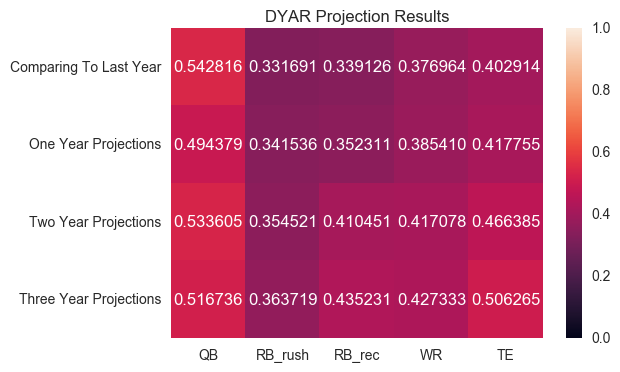

In [104]:
data = np.array([[qb_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1],qb_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0],qb_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0],qb_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0]]
       ,[rb_stats_rush[['DYAR','DYAR_t-1']].corr()['DYAR'][1],rb_stats_rush_1[['DYAR','EDYAR']].corr()['EDYAR'][0],rb_stats_rush_2[['DYAR','EDYAR']].corr()['EDYAR'][0],rb_stats_rush_3[['DYAR','EDYAR']].corr()['EDYAR'][0]]
       ,[rb_stats_rec[['DYAR','DYAR_t-1']].corr()['DYAR'][1],rb_stats_rec_1[['DYAR','EDYAR']].corr()['EDYAR'][0],rb_stats_rec_2[['DYAR','EDYAR']].corr()['EDYAR'][0],rb_stats_rec_3[['DYAR','EDYAR']].corr()['EDYAR'][0]] 
       ,[wr_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1],wr_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0],wr_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0],wr_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0]]
       ,[te_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1],te_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0],te_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0],te_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0]]])
ind = ['Comparing To Last Year','One Year Projections','Two Year Projections','Three Year Projections']
correlations = pd.DataFrame(np.transpose(data),columns = ['QB','RB_rush','RB_rec','WR','TE'],index=ind)
ax = sns.heatmap(correlations, annot=True, fmt="f",vmin = 0.0,vmax = 1.0)
ax.set_title('DYAR Projection Results')
plt.show()


## Comparing Last Year's Yards to Yards Projections

In [105]:
#Get aging model for Yards
rb_age_rush = delta_model("RB_rush",'Yds')
rb_age_rec = delta_model("RB_rec",'Yds')
qb_age = delta_model("QB",'Yds')
wr_age = delta_model("WR",'Yds')
te_age = delta_model("TE",'Yds')

#Get aging penalties for yards
rb_pens_rush = get_age_pens(rb_age_rush,'rb','Yds')
rb_pens_rec = get_age_pens(rb_age_rec,'rb','Yds')
qb_pens = get_age_pens(qb_age,'qb','Yds')
wr_pens = get_age_pens(wr_age,'wr','Yds')
te_pens = get_age_pens(te_age,'te','Yds')

#one year projections
rb_stats_rush_e = get_one_year_projections('rb_rush','Yds')
rb_stats_rec_e = get_one_year_projections('rb_rec','Yds')
qb_stats_e = get_one_year_projections('qb','Yds')
wr_stats_e = get_one_year_projections('wr','Yds')
te_stats_e = get_one_year_projections('te','Yds')

#two year projections
rb_stats_rush_2e = get_two_year_projections('rb_rush','Yds',rb_Yds_coefs2,rb_rushes_coefs2)
rb_stats_rec_2e = get_two_year_projections('rb_rec','Yds',rb_rYds_coefs2,rb_targets_coefs2)
qb_stats_2e = get_two_year_projections('qb','Yds',qb_Yds_coefs2,qb_passes_coefs2)
wr_stats_2e = get_two_year_projections('wr','Yds',qb_Yds_coefs2,wr_targets_coefs2)
te_stats_2e = get_two_year_projections('te','Yds',qb_Yds_coefs2,te_targets_coefs2)

#three year projections
rb_stats_rush_3e = get_three_year_projections('rb_rush','Yds',rb_Yds_coefs3,rb_rushes_coefs3)
rb_stats_rec_3e = get_three_year_projections('rb_rec','Yds',rb_rYds_coefs3,rb_targets_coefs3)
qb_stats_3e = get_three_year_projections('qb','Yds',qb_Yds_coefs3,qb_passes_coefs3)
wr_stats_3e = get_three_year_projections('wr','Yds',wr_Yds_coefs3,wr_targets_coefs3)
te_stats_3e = get_three_year_projections('te','Yds',te_Yds_coefs3,te_targets_coefs3)

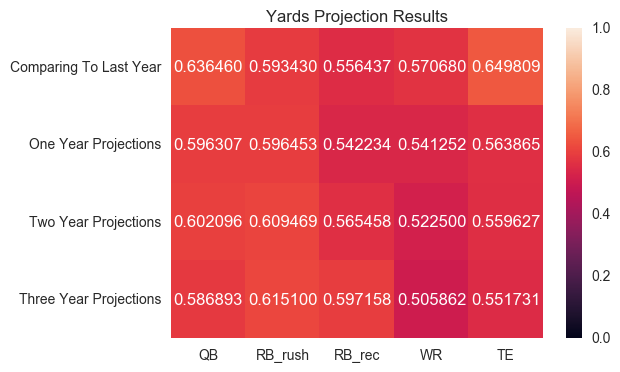

In [106]:
data = np.array([[qb_stats[['Yds','Yds_t-1']].corr()['Yds'][1],qb_stats_e[['Yds','EYds']].corr()['EYds'][0],qb_stats_2e[['Yds','EYds']].corr()['EYds'][0],qb_stats_3e[['Yds','EYds']].corr()['EYds'][0]]
       ,[rb_stats_rush[['Yds','Yds_t-1']].corr()['Yds'][1],rb_stats_rush_e[['Yds','EYds']].corr()['EYds'][0],rb_stats_rush_2e[['Yds','EYds']].corr()['EYds'][0],rb_stats_rush_3e[['Yds','EYds']].corr()['EYds'][0]]
       ,[rb_stats_rec[['Yds','Yds_t-1']].corr()['Yds'][1],rb_stats_rec_e[['Yds','EYds']].corr()['EYds'][0],rb_stats_rec_2e[['Yds','EYds']].corr()['EYds'][0],rb_stats_rec_3e[['Yds','EYds']].corr()['EYds'][0]] 
       ,[wr_stats[['Yds','Yds_t-1']].corr()['Yds'][1],wr_stats_e[['Yds','EYds']].corr()['EYds'][0],wr_stats_2e[['Yds','EYds']].corr()['EYds'][0],wr_stats_3e[['Yds','EYds']].corr()['EYds'][0]]
       ,[te_stats[['Yds','Yds_t-1']].corr()['Yds'][1],te_stats_e[['Yds','EYds']].corr()['EYds'][0],te_stats_2e[['Yds','EYds']].corr()['EYds'][0],te_stats_3e[['Yds','EYds']].corr()['EYds'][0]]])
ind = ['Comparing To Last Year','One Year Projections','Two Year Projections','Three Year Projections']
correlations = pd.DataFrame(np.transpose(data),columns = ['QB','RB_rush','RB_rec','WR','TE'],index=ind)
ax = sns.heatmap(correlations, annot=True, fmt="f",vmin = 0.0,vmax = 1.0)
ax.set_title('Yards Projection Results')
plt.show()

## Current Year Projections

In [107]:
#Using DYAR aging curve
rb_age_rush = delta_model("RB_rush",'DYAR')
rb_age_rec = delta_model("RB_rec",'DYAR')
qb_age = delta_model("QB",'DYAR')
wr_age = delta_model("WR",'DYAR')
te_age = delta_model("TE",'DYAR')
rb_pens_rush = get_age_pens(rb_age_rush,'rb','DYAR')
rb_pens_rec = get_age_pens(rb_age_rec,'rb','DYAR')
qb_pens = get_age_pens(qb_age,'qb','DYAR')
wr_pens = get_age_pens(wr_age,'wr','DYAR')
te_pens = get_age_pens(te_age,'te','DYAR')


#Use past two years to generate projections for current year
rb_current_projs = get_two_year_projections('rb_rush','DYAR',rb_dyar_coefs2,rb_rushes_coefs2, current = True)[['Player','Weighted_Rushes_2','EDYAR']]
rb_rec_current_projs = get_two_year_projections('rb_rec','DYAR',rb_rdyar_coefs2,rb_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EDYAR']]
qb_current_projs = get_two_year_projections('qb','DYAR',qb_dyar_coefs2,qb_passes_coefs2,current = True)[['Player','Weighted_Passes_2','EDYAR']]
wr_current_projs = get_two_year_projections('wr','DYAR',wr_dyar_coefs2,wr_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EDYAR']]
te_current_projs = get_two_year_projections('te','DYAR',te_dyar_coefs2,te_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EDYAR']]

#Get projections for players who were rookies this past yaer
rb_rooks_current_projs = get_one_year_projections('rb_rush','DYAR',current = True)
rb_rooks_current_projs = rb_rooks_current_projs[pd.isnull(rb_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Rushes','EDYAR']]

rb_rec_rooks_current_projs = get_one_year_projections('rb_rec','DYAR',current = True)
rb_rec_rooks_current_projs = rb_rec_rooks_current_projs[pd.isnull(rb_rec_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Targets','EDYAR']]

rb_rec_rooks_current_projs = get_one_year_projections('rb_rec','DYAR',current = True)
rb_rec_rooks_current_projs = rb_rec_rooks_current_projs[pd.isnull(rb_rec_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Targets','EDYAR']]

qb_rooks_current_projs = get_one_year_projections('qb','DYAR',current = True)
qb_rooks_current_projs = qb_rooks_current_projs[pd.isnull(qb_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Passes','EDYAR']]

wr_rooks_current_projs = get_one_year_projections('wr','DYAR',current = True)
wr_rooks_current_projs = wr_rooks_current_projs[pd.isnull(wr_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Targets','EDYAR']]

te_rooks_current_projs = get_one_year_projections('te','DYAR',current = True)
te_rooks_current_projs = te_rooks_current_projs[pd.isnull(te_rooks_current_projs['DYAR_t-1'])][['Player','Weighted_Targets','EDYAR']]

#rename columns so both dfs can be combined
rb_current_projs.rename(columns = {'Weighted_Rushes_2':'Weighted_Rushes'}, inplace = True)
rb_rec_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)
qb_current_projs.rename(columns = {'Weighted_Passes_2':'Weighted_Passes'}, inplace = True)
wr_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)
te_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)

#combine dfs
rb_current_dyar = pd.concat([rb_rooks_current_projs[['Player','Weighted_Rushes','EDYAR']],rb_current_projs[['Player','Weighted_Rushes','EDYAR']]]).sort_values('EDYAR',ascending = False).round(decimals = 2)
rb_current_rdyar = pd.concat([rb_rec_rooks_current_projs[['Player','Weighted_Targets','EDYAR']],rb_rec_current_projs[['Player','Weighted_Targets','EDYAR']]]).sort_values('EDYAR',ascending = False).round(decimals = 2)
qb_current_dyar = pd.concat([qb_rooks_current_projs[['Player','Weighted_Passes','EDYAR']],qb_current_projs[['Player','Weighted_Passes','EDYAR']]]).sort_values('EDYAR',ascending = False).round(decimals = 2)
wr_current_dyar = pd.concat([wr_rooks_current_projs[['Player','Weighted_Targets','EDYAR']],wr_current_projs[['Player','Weighted_Targets','EDYAR']]]).sort_values('EDYAR',ascending = False).round(decimals = 2)
te_current_dyar = pd.concat([te_rooks_current_projs[['Player','Weighted_Targets','EDYAR']],te_current_projs[['Player','Weighted_Targets','EDYAR']]]).sort_values('EDYAR',ascending = False).round(decimals = 2)

In [108]:
#Get aging model for Yards
rb_age_rush = delta_model("RB_rush",'Yds')
rb_age_rec = delta_model("RB_rec",'Yds')
qb_age = delta_model("QB",'Yds')
wr_age = delta_model("WR",'Yds')
te_age = delta_model("TE",'Yds')

#Get aging penalties for yards
rb_pens_rush = get_age_pens(rb_age_rush,'rb','Yds')
rb_pens_rec = get_age_pens(rb_age_rec,'rb','Yds')
qb_pens = get_age_pens(qb_age,'qb','Yds')
wr_pens = get_age_pens(wr_age,'wr','Yds')
te_pens = get_age_pens(te_age,'te','Yds')


#Use past two years to generate projections for current year
rb_current_projs = get_two_year_projections('rb_rush','Yds',rb_Yds_coefs2,rb_rushes_coefs2, current = True)[['Player','Weighted_Rushes_2','EYds']]
rb_rec_current_projs = get_two_year_projections('rb_rec','Yds',rb_rYds_coefs2,rb_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EYds']]
qb_current_projs = get_two_year_projections('qb','Yds',qb_Yds_coefs2,qb_passes_coefs2,current = True)[['Player','Weighted_Passes_2','EYds']]
wr_current_projs = get_two_year_projections('wr','Yds',wr_Yds_coefs2,wr_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EYds']]
te_current_projs = get_two_year_projections('te','Yds',te_Yds_coefs2,te_targets_coefs2,current = True)[['Player','Weighted_Targets_2','EYds']]

#Get projections for players who were rookies this past yaer
rb_rooks_current_projs = get_one_year_projections('rb_rush','Yds',current = True)
rb_rooks_current_projs = rb_rooks_current_projs[pd.isnull(rb_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Rushes','EYds']]

rb_rec_rooks_current_projs = get_one_year_projections('rb_rec','Yds',current = True)
rb_rec_rooks_current_projs = rb_rec_rooks_current_projs[pd.isnull(rb_rec_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Targets','EYds']]

rb_rec_rooks_current_projs = get_one_year_projections('rb_rec','Yds',current = True)
rb_rec_rooks_current_projs = rb_rec_rooks_current_projs[pd.isnull(rb_rec_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Targets','EYds']]

qb_rooks_current_projs = get_one_year_projections('qb','Yds',current = True)
qb_rooks_current_projs = qb_rooks_current_projs[pd.isnull(qb_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Passes','EYds']]

wr_rooks_current_projs = get_one_year_projections('wr','Yds',current = True)
wr_rooks_current_projs = wr_rooks_current_projs[pd.isnull(wr_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Targets','EYds']]

te_rooks_current_projs = get_one_year_projections('te','Yds',current = True)
te_rooks_current_projs = te_rooks_current_projs[pd.isnull(te_rooks_current_projs['Yds_t-1'])][['Player','Weighted_Targets','EYds']]

#rename columns so both dfs can be combined
rb_current_projs.rename(columns = {'Weighted_Rushes_2':'Weighted_Rushes'}, inplace = True)
rb_rec_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)
qb_current_projs.rename(columns = {'Weighted_Passes_2':'Weighted_Passes'}, inplace = True)
wr_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)
te_current_projs.rename(columns = {'Weighted_Targets_2':'Weighted_Targets'}, inplace = True)

#combine dfs
rb_current_yds = pd.concat([rb_rooks_current_projs[['Player','Weighted_Rushes','EYds']],rb_current_projs[['Player','Weighted_Rushes','EYds']]]).sort_values('EYds',ascending = False).round(decimals = 2)
rb_current_ryds = pd.concat([rb_rec_rooks_current_projs[['Player','Weighted_Targets','EYds']],rb_rec_current_projs[['Player','Weighted_Targets','EYds']]]).sort_values('EYds',ascending = False).round(decimals = 2)
qb_current_yds = pd.concat([qb_rooks_current_projs[['Player','Weighted_Passes','EYds']],qb_current_projs[['Player','Weighted_Passes','EYds']]]).sort_values('EYds',ascending = False).round(decimals = 2)
wr_current_yds = pd.concat([wr_rooks_current_projs[['Player','Weighted_Targets','EYds']],wr_current_projs[['Player','Weighted_Targets','EYds']]]).sort_values('EYds',ascending = False).round(decimals = 2)
te_current_yds = pd.concat([te_rooks_current_projs[['Player','Weighted_Targets','EYds']],te_current_projs[['Player','Weighted_Targets','EYds']]]).sort_values('EYds',ascending = False).round(decimals = 2)



In [109]:
rb_current_dyar.merge(rb_current_yds, on = ['Player','Weighted_Rushes'],how = 'inner').to_csv("Projections/rb_rush.csv")
rb_current_rdyar.merge(rb_current_ryds, on = ['Player','Weighted_Targets'],how = 'inner').to_csv("Projections/rb_rec.csv")
qb_current_dyar.merge(qb_current_yds, on = ['Player','Weighted_Passes'],how = 'inner').to_csv("Projections/qb.csv")
wr_current_dyar.merge(wr_current_yds, on = ['Player','Weighted_Targets'],how = 'inner').to_csv("Projections/wr.csv")
te_current_dyar.merge(te_current_yds, on = ['Player','Weighted_Targets'],how = 'inner').to_csv("Projections/te.csv")